# IMU Fusion Algorithms
Using Machine Learning

In [135]:
import os

In [136]:
path_to_dataset = 'datasets/'
datasets = os.listdir(path_to_dataset)

In [137]:
data_df_file = 'global_observations.csv'
# data_df_file = 'datasets/Forbury_Road-2023-12-15_07-55-45/observations.csv'

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [139]:
def gpsgraph(df_gps):
    longitude_gps = df_gps['longitude'].values
    latitude_gps = df_gps['latitude'].values

    latitude_gps = latitude_gps - latitude_gps[0]
    longitude_gps = longitude_gps  - longitude_gps[0]

    plt.figure()
    plt.scatter(longitude_gps, latitude_gps, label='GPS Path', marker='o')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GPS Path Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()


Reading the dataset selected

In [140]:
df = pd.read_csv(data_df_file,parse_dates=True)
sources = df.source.unique()

i = 0
for file in sources:
    print(i,file)
    i+=1

0 2023-04-02_19-22-16
1 2023-04-19_07-21-10
2 2023-04-21_17-03-28
3 2023-06-02_06-34-39
4 2023-06-02_12-14-13
5 2023-06-02_13-28-32
6 2023-06-03_06-13-40
7 2023-06-03_07-09-39
8 2023-07-05_07-44-33
9 2023-07-26_06-26-10
10 Earley-2023-12-08_07-39-28
11 Forbury_Road-2023-12-15_07-55-45
12 Forbury_Road_(stop_EL)-2023-11-28_14-02-13
13 Reading_College-2023-12-02_15-45-53
14 Station_Road-2023-12-08_07-53-14
15 Twyford_railway_station-2023-12-02_09-05-35


In [141]:
_start = 12
_end = 14
_source = sources[_start:_end+1]
_source

array(['Forbury_Road_(stop_EL)-2023-11-28_14-02-13',
       'Reading_College-2023-12-02_15-45-53',
       'Station_Road-2023-12-08_07-53-14'], dtype=object)

In [142]:
df_selected = df[df['source'].isin(_source)]
# df_selected = df

Select Testing Set

In [172]:
_start_t = 2   
_end_t = 2
_test = sources[_start_t:_end_t+1]
_test

array(['2023-04-21_17-03-28'], dtype=object)

In [124]:
# df_test = pd.read_csv('datasets/Station_Road-2023-12-08_07-53-14/observations.csv',parse_dates=True)

In [144]:
df_test = df[df['source'].isin(_source)]

In [134]:
# Free Memory
del df

NameError: name 'df' is not defined

#### Dataset Description

In [145]:
df_imu = df_selected[['time','x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro','x_mag', 'y_mag', 'z_mag']]
print(
    "Duration:",
    round((df_imu['time'].values[-1] - df_imu['time'].values[0])/6e+10,2),
    " minutes"
)

Duration: 14112.7  minutes


In [146]:
df_gps = df_selected[['time','latitude','longitude','latitude_delta','longitude_delta']]

In [147]:
print("IMU Datapoints:",df_imu.shape)
print("GPS Datapoints:",df_gps.shape)

IMU Datapoints: (35250, 10)
GPS Datapoints: (35250, 5)


In [148]:
df_selected.columns

Index(['time', 'x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro',
       'x_mag', 'y_mag', 'z_mag', 'longitude', 'latitude', 'longitude_delta',
       'latitude_delta', 'source'],
      dtype='object')

## Ground Truth

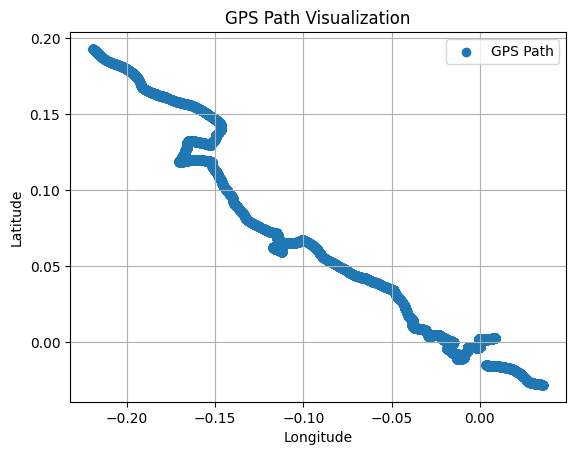

In [149]:
gpsgraph(df_gps)

## Determining position change from GPS Coordinates

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

In [151]:
cols_X = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro','x_mag', 'y_mag', 'z_mag']
cols_Y = ['latitude_delta','longitude_delta']

In [152]:
X = df_imu[cols_X].values
y = df_gps[cols_Y].values

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

DEEP LEARNING

In [28]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

In [154]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

In [79]:
# model = Sequential()
# model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# model.add(LSTM(32))
# model.add(Dense(df_gps.shape[1]))  # Output layer
# # Compile the model
# model.compile(optimizer='adam', loss='mse')


In [155]:
# Creating and training the MultiOutputRegressor with SVR
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
multioutput_regressor = MultiOutputRegressor(svr_model)
multioutput_regressor.fit(X_train_scaled, y_train_scaled)

# Making predictions on the test set
X_test_scaled = scaler_X.transform(X_test)
y_pred_scaled = multioutput_regressor.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])

In [157]:
# Calculating Mean Squared Error (MSE) for each target

mse1,mse2

(0.005634893128369886, 0.006073477156247839)

In [169]:
import pickle

In [171]:
with open('models/svr_multi.model','wb') as m:
    pickle.dump(multioutput_regressor,m)

### Model Testing

In [246]:
_start_t = 7
_end_t = 7
_test = sources[_start_t:_end_t+1]
_test

array(['2023-06-03_07-09-39'], dtype=object)

In [247]:
df_test = df[df['source'].isin(_test)]

In [248]:
df_gps_test = df_test[['time','longitude','latitude']]
df_imu_test = df_test[cols_X]

In [251]:
df_gps_test

,time,longitude,latitude
2408928,1685776181113697800,-0.544618,51.505044
2408929,1685776182073704200,-0.544618,51.505044
2408930,1685776183033705700,-0.544618,51.505044
2408931,1685776184111298600,-0.544537,51.505277
2408932,1685776185065363500,-0.544537,51.505277
...,...,...,...
2455790,1685791284580769800,-0.544633,51.505383
2455791,1685791285280067300,-0.544537,51.505277
2455792,1685791285379459800,-0.544615,51.505040
2455793,1685791286234232800,-0.544537,51.505277


In [249]:
print("IMU Datapoints:",df_imu_test.shape)
print("GPS Datapoints:",df_gps_test.shape)

IMU Datapoints: (46867, 9)
GPS Datapoints: (46867, 3)


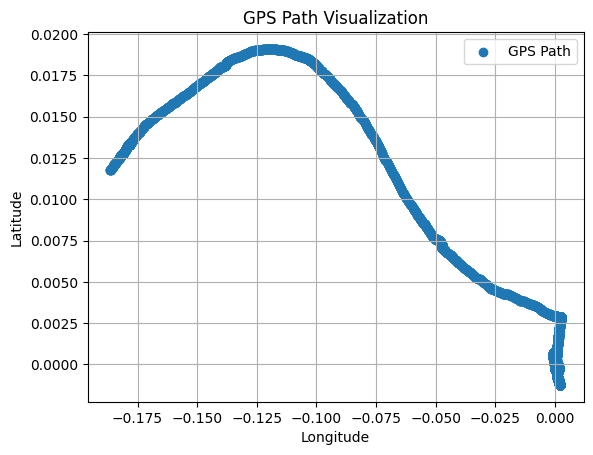

In [250]:
gpsgraph(df_gps_test)

In [252]:
X_input = df_test[cols_X].values

In [253]:
X_input_scaled = scaler_X.transform(X_input)

In [254]:
preds = multioutput_regressor.predict(X_input_scaled)

In [255]:
df_pred = pd.DataFrame()
df_pred['longitude_change'] = preds[:,0]
df_pred['latitude_change'] = preds[:,1]

df_pred['longitudes'] = np.cumsum(df_pred['longitude_change'].values)
df_pred['latitudes'] = np.cumsum(df_pred['latitude_change'].values)

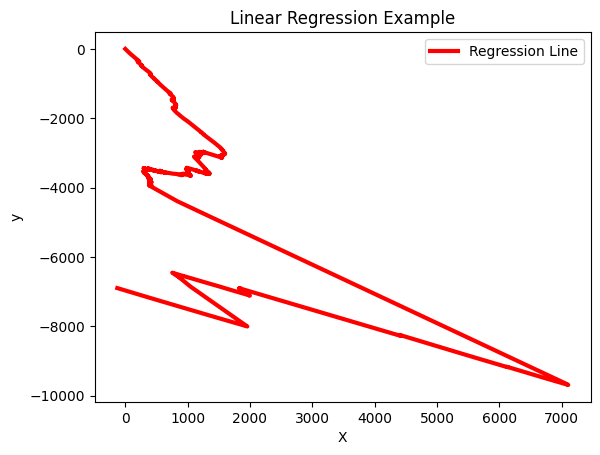

In [256]:
plt.plot(df_pred['longitudes'],df_pred['latitudes'], color='red', linewidth=3, label='Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Example')
plt.legend()
plt.show()